In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import random

import time
from datetime import datetime
import sqlite3 as sql

%matplotlib inline

import datetime as dt

In [2]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, make_scorer, accuracy_score
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, classification_report
from sklearn.cluster import MeanShift, estimate_bandwidth

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
train_df4 = pd.read_csv("../dataset/churn_dataset.csv")
train_df4.head()

,userId,page_turn_count,view_duration,brochure_id,origin,year,month,day,app_origin,model,...,churn,last_year,last_month,last_day,first_year,first_month,first_day,product_cat__com-bonial-kaufda,product_cat__de-kaufda-android,product_cat__de.kaufda.kaufda
0,9491a960-206a-4a58-9177-e78cb1f05e70,0.080000,0.028102,672239440,0,2017,4,30,0.0,34,...,0.0,2017,7,31,2017,4,2,1,0,0
1,9491a960-206a-4a58-9177-e78cb1f05e70,0.005333,0.005463,673861625,0,2017,4,30,0.0,34,...,0.0,2017,7,31,2017,4,2,1,0,0
2,9491a960-206a-4a58-9177-e78cb1f05e70,0.002667,0.007946,660764240,0,2017,4,30,0.0,34,...,0.0,2017,7,31,2017,4,2,1,0,0
3,fa623647-dfc9-49b4-bbb6-77cbacd599f4,0.170667,0.046186,672658544,0,2017,4,30,0.0,40,...,1.0,2017,6,21,2017,4,1,1,0,0
4,9491a960-206a-4a58-9177-e78cb1f05e70,0.002667,0.012664,660764240,0,2017,4,30,0.0,34,...,0.0,2017,7,31,2017,4,2,1,0,0


In [5]:
train_df5 = train_df4.copy()
#train_df4 = train_df4.drop(columns='userId')

In [6]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
train_df4 = reduce_mem_usage(train_df4)

Mem. usage decreased to 15.44 Mb (76.0% reduction)


In [8]:
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
train_df4['userId'] = labelencoder.fit_transform(train_df4['userId'])

In [9]:
X_no = train_df4[train_df4.churn == 0]
X_yes = train_df4[train_df4.churn == 1]

In [10]:
X_yes_upsampled = X_yes.sample(n=len(X_no), replace=True, random_state=42)
print(len(X_yes_upsampled))

265139


Text(0.5, 1.0, 'Class Distribution After Resampling')

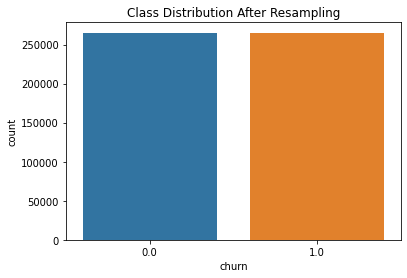

In [11]:
X_upsampled = X_no.append(X_yes_upsampled).reset_index(drop=True)
sns.countplot('churn', data=X_upsampled).set_title('Class Distribution After Resampling')

In [12]:
X = X_upsampled.drop(['churn'], axis=1) #features (independent variables)
y = X_upsampled['churn'] #target (dependent variable)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [14]:
X_test.head()

,userId,page_turn_count,view_duration,brochure_id,origin,year,month,day,app_origin,model,...,install_day,last_year,last_month,last_day,first_year,first_month,first_day,product_cat__com-bonial-kaufda,product_cat__de-kaufda-android,product_cat__de.kaufda.kaufda
427517,6552,0.002666,0.013908,660764295,0,2017,6,5,0.0,110,...,1.0,2017,7,11,2017,4,1,1,0,0
10486,6343,0.072021,0.014153,670440838,0,2017,4,24,0.0,110,...,24.0,2017,7,30,2017,4,24,1,0,0
293093,3559,0.135986,0.024094,690774029,0,2017,6,17,0.0,166,...,3.0,2017,6,26,2017,4,3,1,0,0
488448,8917,0.061340,0.040222,678600077,0,2017,5,26,-1.0,87,...,1.0,2017,6,28,2017,4,30,0,0,0
26533,3465,0.032013,0.032532,666027994,0,2017,4,9,0.0,157,...,5.0,2017,7,31,2017,4,5,1,0,0


**#RidgeClassifier**

In [15]:
clf_ridge = RidgeClassifier() #create a ridge classifier object
clf_ridge.fit(X_train, y_train) #train the model

RidgeClassifier()

In [18]:
X_train.head()

,userId,page_turn_count,view_duration,brochure_id,origin,year,month,day,app_origin,model,...,install_day,last_year,last_month,last_day,first_year,first_month,first_day,product_cat__com-bonial-kaufda,product_cat__de-kaufda-android,product_cat__de.kaufda.kaufda
201104,4207,0.034668,0.010429,703347176,1,2017,7,30,1.0,110,...,9.0,2017,7,31,2017,5,9,1,0,0
343106,9103,0.149292,0.051147,685524964,0,2017,6,5,0.0,110,...,16.0,2017,7,6,2017,4,16,1,0,0
299308,181,0.010666,0.006454,681241342,0,2017,5,22,-1.0,87,...,1.0,2000,1,1,2000,1,1,0,0,0
279258,4271,0.042664,0.019119,656072535,0,2017,4,10,0.0,110,...,10.0,2017,4,12,2017,4,10,1,0,0
407581,3703,0.144043,0.018631,690668565,0,2017,6,18,0.0,110,...,2.0,2017,7,5,2017,4,2,0,1,0


Feature: 0, Score: -0.00000
Feature: 1, Score: -0.26469
Feature: 2, Score: 0.04708
Feature: 3, Score: -0.00000
Feature: 4, Score: -0.89623
Feature: 5, Score: 0.00000
Feature: 6, Score: -0.12517
Feature: 7, Score: -0.00182
Feature: 8, Score: 0.72538
Feature: 9, Score: -0.00001
Feature: 10, Score: 0.00007
Feature: 11, Score: 0.21986
Feature: 12, Score: -1.09434
Feature: 13, Score: -0.05682
Feature: 14, Score: -0.05418
Feature: 15, Score: -0.64115
Feature: 16, Score: -0.02404
Feature: 17, Score: -0.05418
Feature: 18, Score: 1.29040
Feature: 19, Score: 0.06215
Feature: 20, Score: 0.41073
Feature: 21, Score: 0.40205
Feature: 22, Score: -0.79984


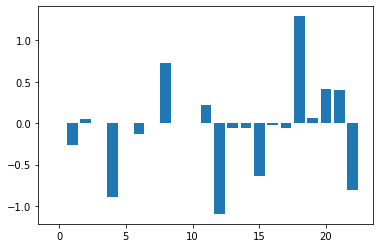

In [17]:
ridge_importance = clf_ridge.coef_[0]
# summarize feature importance
for i,v in enumerate(ridge_importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(ridge_importance))], ridge_importance)
plt.show()

In [16]:
ridge_pred_test = clf_ridge.predict(X_test)

In [17]:
accuracy_score(y_test, ridge_pred_test)

0.8597816248019914

In [18]:
print(classification_report(y_test, ridge_pred_test))

              precision    recall  f1-score   support

         0.0       0.91      0.80      0.85     53180
         1.0       0.82      0.92      0.87     52876

    accuracy                           0.86    106056
   macro avg       0.87      0.86      0.86    106056
weighted avg       0.87      0.86      0.86    106056



**#RandomForestClassifier**

In [19]:
n_estimators = [700]
max_depth = [10, 8]
min_samples_split = [10, 5]
min_samples_leaf = [5, 3]

In [20]:
hyper_random = {"n_estimators":n_estimators,
                "max_depth":max_depth,
                "min_samples_split":min_samples_split,
                "min_samples_leaf":min_samples_leaf}

In [21]:
start = time.time()
print(start)
clf_rf_tuned = GridSearchCV(RandomForestClassifier(), hyper_random, 
                            cv = 5, verbose = 1, 
                            n_jobs = -1)
clf_rf_tuned.fit(X_train, y_train)

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("\nÇalışma süresi: "+"{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))


1648883553.967665
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Çalışma süresi: 00:23:45.21


In [22]:
best_params_random = clf_rf_tuned.best_params_
print(best_params_random)

{'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 700}


In [23]:
CV_clf_rf = RandomForestClassifier(max_depth=best_params_random["max_depth"],
                                   min_samples_leaf=best_params_random["min_samples_leaf"],
                                   min_samples_split=best_params_random["min_samples_split"],
                                   n_estimators= best_params_random["n_estimators"])

In [24]:
CV_clf_rf.fit(X_train, y_train)
y_test_predict_random = CV_clf_rf.predict_proba(X_test)[:, 1]
yhat_random = CV_clf_rf.predict(X_test)
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_random, n_bins=10)

In [25]:
print(classification_report(y_test, yhat_random))

              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90     53180
         1.0       0.89      0.93      0.91     52876

    accuracy                           0.90    106056
   macro avg       0.91      0.90      0.90    106056
weighted avg       0.91      0.90      0.90    106056



In [26]:
final_df = pd.DataFrame()


In [27]:
final_df['userId'] = X_test.userId
final_df['Actual_Churn'] = y_test
final_df['Random_Forest_Probability'] = y_test_predict_random
final_df.shape

(106056, 3)

**#CalibratedClassifierCV**

In [28]:
start = time.time()

# Create a corrected classifier.

clf_sigmoid = CalibratedClassifierCV(CV_clf_rf, cv=10, method='sigmoid')
clf_sigmoid.fit(X_train, y_train)
y_test_predict_random_calibrated = clf_sigmoid.predict_proba(X_test)[:, 1]
yhat_calibrated_random = clf_sigmoid.predict(X_test)
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_random_calibrated, n_bins=10)


end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("\nÇalışma süresi: "+"{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))


Çalışma süresi: 00:26:25.61


In [29]:
print(classification_report(y_test, yhat_calibrated_random))

              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90     53180
         1.0       0.89      0.92      0.91     52876

    accuracy                           0.90    106056
   macro avg       0.90      0.90      0.90    106056
weighted avg       0.90      0.90      0.90    106056



In [30]:
final_df['Calibrated_Random_Forest_Probability'] = y_test_predict_random_calibrated
final_df.shape

(106056, 4)

In [31]:
print(classification_report(y_test, ridge_pred_test))

              precision    recall  f1-score   support

         0.0       0.91      0.80      0.85     53180
         1.0       0.82      0.92      0.87     52876

    accuracy                           0.86    106056
   macro avg       0.87      0.86      0.86    106056
weighted avg       0.87      0.86      0.86    106056



In [32]:
print(classification_report(y_test, yhat_random))

              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90     53180
         1.0       0.89      0.93      0.91     52876

    accuracy                           0.90    106056
   macro avg       0.91      0.90      0.90    106056
weighted avg       0.91      0.90      0.90    106056



In [33]:
print(classification_report(y_test, yhat_calibrated_random))

              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90     53180
         1.0       0.89      0.92      0.91     52876

    accuracy                           0.90    106056
   macro avg       0.90      0.90      0.90    106056
weighted avg       0.90      0.90      0.90    106056



**#GaussianNaiveBias**

In [34]:
start = time.time()
# Uncalibrated
clf_nb = GaussianNB()
clf_nb.fit(X_train, y_train)
y_test_predict_nb = clf_nb.predict_proba(X_test)[:, 1]
yhat_nb = clf_nb.predict(X_test)
fraction_of_positives_nb, mean_predicted_value_nb = calibration_curve(y_test, y_test_predict_nb, n_bins=10)

#plt.plot(mean_predicted_value_nb, fraction_of_positives_nb, 's-', label='Uncalibrated')

# Calibrated
clf_sigmoid_nb = CalibratedClassifierCV(clf_nb, cv=10, method='isotonic')
clf_sigmoid_nb.fit(X_train, y_train)
y_test_predict_nb_calib = clf_sigmoid_nb.predict_proba(X_test)[:, 1]
yhat_calibrated_nb = clf_sigmoid_nb.predict(X_test)
fraction_of_positives_nb_calib, mean_predicted_value_nb_calib = calibration_curve(y_test, y_test_predict_nb_calib, n_bins=10)

#plt.plot(mean_predicted_value_nb_calib, fraction_of_positives_nb_calib, 's-', color='red', label='Calibrated (Isotonic)')

# Calibrated, Platt
clf_sigmoid_nb_calib_sig = CalibratedClassifierCV(clf_nb, cv=10, method='sigmoid')
clf_sigmoid_nb_calib_sig.fit(X_train, y_train)

y_test_predict_nb_calib_platt = clf_sigmoid_nb_calib_sig.predict_proba(X_test)[:, 1]
yhat_calibrated_platt = clf_sigmoid_nb_calib_sig.predict(X_test)

fraction_of_positives_nb_calib_platt, mean_predicted_value_nb_calib_platt = calibration_curve(y_test, y_test_predict_nb_calib_platt, n_bins=10)
#plt.plot(mean_predicted_value_nb_calib_platt, fraction_of_positives_nb_calib_platt, 's-', color='orange', label='Calibrated (Platt)')

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("\nÇalışma süresi: "+"{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))


Çalışma süresi: 00:00:08.10


In [35]:
print(classification_report(y_test, yhat_nb))

              precision    recall  f1-score   support

         0.0       0.72      0.62      0.66     53180
         1.0       0.66      0.76      0.71     52876

    accuracy                           0.69    106056
   macro avg       0.69      0.69      0.69    106056
weighted avg       0.69      0.69      0.69    106056



In [36]:
print(classification_report(y_test, yhat_calibrated_nb))


              precision    recall  f1-score   support

         0.0       0.78      0.54      0.64     53180
         1.0       0.65      0.85      0.73     52876

    accuracy                           0.69    106056
   macro avg       0.71      0.69      0.68    106056
weighted avg       0.71      0.69      0.68    106056



In [37]:
print(classification_report(y_test, yhat_calibrated_platt))

              precision    recall  f1-score   support

         0.0       0.71      0.63      0.67     53180
         1.0       0.67      0.74      0.70     52876

    accuracy                           0.68    106056
   macro avg       0.69      0.68      0.68    106056
weighted avg       0.69      0.68      0.68    106056



In [38]:
final_df['Naive_Bias_Probability'] = y_test_predict_nb
final_df['Isotonic_Calibrated_Naive_Bias_Probability'] = y_test_predict_nb_calib
final_df['Sigmoid_Calibrated_Naive_Bias_Probability'] = y_test_predict_nb_calib_platt

final_df.shape

(106056, 7)

In [39]:
final_df.head()

,userId,Actual_Churn,Random_Forest_Probability,Calibrated_Random_Forest_Probability,Naive_Bias_Probability,Isotonic_Calibrated_Naive_Bias_Probability,Sigmoid_Calibrated_Naive_Bias_Probability
427517,6552,1.0,0.379130,0.247146,0.648125,0.684556,0.741489
10486,6343,0.0,0.137587,0.033723,0.590879,0.680801,0.652669
293093,3559,1.0,0.915144,0.971234,0.381928,0.323934,0.286382
488448,8917,1.0,0.909400,0.970192,0.516978,0.598095,0.521183
26533,3465,0.0,0.042955,0.015609,0.626129,0.684556,0.709142


**#Train Results**


In [40]:
# Random Forest
y_predict_train = CV_clf_rf.predict_proba(X_train)[:, 1]
yhat_predict_train = CV_clf_rf.predict(X_train)

# Calibrated Random Forest
y_predict_crf_train = clf_sigmoid.predict_proba(X_train)[:, 1]
yhat_predict_crf_train = clf_sigmoid.predict(X_train)

#NB

y_predict_nb_train = clf_nb.predict_proba(X_train)[:, 1]
yhat_predict_nb_train = clf_nb.predict(X_train)

# Isotonic
y_predict_nb_isotonic_train = clf_sigmoid_nb.predict_proba(X_train)[:, 1]
yhat_predict_isotonic_train = clf_sigmoid_nb.predict(X_train)

# Sigmoid
y_predict_nb_sigmoid_train = clf_sigmoid_nb_calib_sig.predict_proba(X_train)[:, 1]
yhat_predict_sigmoid_train = clf_sigmoid_nb_calib_sig.predict(X_train)

In [104]:
final_train_df = pd.DataFrame()
final_train_df['userId'] = X_train.userId
final_train_df['Actual_Churn'] = y_train

final_train_df['Random_Forest_Probability'] = y_predict_train
final_train_df['Calibrated_Random_Forest_Probability'] = y_predict_crf_train
final_train_df['Naive_Bias_Probability'] = y_predict_nb_train
final_train_df['Isotonic_Calibrated_Naive_Bias_Probability'] = y_predict_nb_isotonic_train
final_train_df['Sigmoid_Calibrated_Naive_Bias_Probability'] = y_predict_nb_sigmoid_train
final_train_df.shape

(424222, 7)

In [105]:
final_df.shape[0] + final_train_df.shape[0]

530278

In [106]:
churn_df = final_df.append(final_train_df, ignore_index=True)
churn_df.shape

(530278, 7)

In [108]:
churn_df['userId'] = labelencoder.inverse_transform(churn_df['userId'])
churn_df.head()

,userId,Actual_Churn,Random_Forest_Probability,Calibrated_Random_Forest_Probability,Naive_Bias_Probability,Isotonic_Calibrated_Naive_Bias_Probability,Sigmoid_Calibrated_Naive_Bias_Probability
0,985f1fc3-bce0-471e-b7b8-d518de876c26,1.0,0.379130,0.247146,0.648125,0.684556,0.741489
1,9310554d-f01a-4e7d-bffb-00808e1beb3a,0.0,0.137587,0.033723,0.590879,0.680801,0.652669
2,517721da-4043-4ec7-9805-581173ac6113,1.0,0.915144,0.971234,0.381928,0.323934,0.286382
3,c02a56c0-200e-4dae-9add-cae2a779682c,1.0,0.909400,0.970192,0.516978,0.598095,0.521183
4,4f1f7cf8-bfe3-4fea-b176-0cf8dfd80591,0.0,0.042955,0.015609,0.626129,0.684556,0.709142


In [109]:
def calc_churn_score(final_df):
    final_df['Churn_Score'] = (final_df['Random_Forest_Probability']*0.90) + (final_df['Calibrated_Random_Forest_Probability']*0.90) + (final_df['Naive_Bias_Probability']*0.69) + (final_df['Isotonic_Calibrated_Naive_Bias_Probability']*0.69) + (final_df['Sigmoid_Calibrated_Naive_Bias_Probability']*0.68)
    
    def NormalizeData(data):
        return (data - np.min(data)) / (np.max(data) - np.min(data))
    
    final_df['Churn_Score'] = NormalizeData(final_df['Churn_Score'])
    return final_df

In [110]:
churn_df2 = churn_df.groupby(['userId', 'Actual_Churn'], as_index=False)['Random_Forest_Probability', 'Calibrated_Random_Forest_Probability', 'Naive_Bias_Probability', 'Isotonic_Calibrated_Naive_Bias_Probability', 'Sigmoid_Calibrated_Naive_Bias_Probability'].mean()

#rf_list = churn_df.groupby(['userId', 'Actual_Churn'])['Random_Forest_Probability'].mean()
#crf_list = churn_df.groupby(['userId', 'Actual_Churn'])['Calibrated_Random_Forest_Probability'].mean()
#nb_list = churn_df.groupby(['userId', 'Actual_Churn'])['Naive_Bias_Probability'].mean()
#inb_list = churn_df.groupby(['userId', 'Actual_Churn'])['Isotonic_Calibrated_Naive_Bias_Probability'].mean()
#snb_list = churn_df.groupby(['userId', 'Actual_Churn'])['Sigmoid_Calibrated_Naive_Bias_Probability'].mean()

In [112]:
churn_df2.head()

,userId,Actual_Churn,Random_Forest_Probability,Calibrated_Random_Forest_Probability,Naive_Bias_Probability,Isotonic_Calibrated_Naive_Bias_Probability,Sigmoid_Calibrated_Naive_Bias_Probability
0,0002C218-D30F-402E-AE08-1280AD4FB669,1.0,0.731484,0.874370,0.584981,0.649804,0.658299
1,00095350-9e64-4b34-9112-b9869703248b,1.0,0.974088,0.983857,0.646214,0.684556,0.738415
2,00095653-80f8-4fba-93d9-44ae70bb6263,1.0,0.939572,0.978172,0.430832,0.398299,0.370653
3,0010E3BE-81BD-48A3-8282-8C8D0B1F9629,0.0,0.355808,0.306935,0.468026,0.454924,0.452065
4,0015a4a8-99f1-4119-9e10-0ac9773ae48a,1.0,0.977035,0.983986,0.555581,0.650397,0.591459


In [113]:
churn_df2 = calc_churn_score(churn_df2)
churn_df = calc_churn_score(churn_df)

In [114]:
churn_df.head()

,userId,Actual_Churn,Random_Forest_Probability,Calibrated_Random_Forest_Probability,Naive_Bias_Probability,Isotonic_Calibrated_Naive_Bias_Probability,Sigmoid_Calibrated_Naive_Bias_Probability,Churn_Score
0,985f1fc3-bce0-471e-b7b8-d518de876c26,1.0,0.379130,0.247146,0.648125,0.684556,0.741489,0.592558
1,9310554d-f01a-4e7d-bffb-00808e1beb3a,0.0,0.137587,0.033723,0.590879,0.680801,0.652669,0.433397
2,517721da-4043-4ec7-9805-581173ac6113,1.0,0.915144,0.971234,0.381928,0.323934,0.286382,0.714460
3,c02a56c0-200e-4dae-9add-cae2a779682c,1.0,0.909400,0.970192,0.516978,0.598095,0.521183,0.849979
4,4f1f7cf8-bfe3-4fea-b176-0cf8dfd80591,0.0,0.042955,0.015609,0.626129,0.684556,0.709142,0.422157


In [121]:
cols = churn_df.columns.tolist()
cols = cols[:2] + cols[-1:] + cols[2:-1]
cols

['userId',
 'Actual_Churn',
 'Churn_Score',
 'Random_Forest_Probability',
 'Calibrated_Random_Forest_Probability',
 'Naive_Bias_Probability',
 'Isotonic_Calibrated_Naive_Bias_Probability',
 'Sigmoid_Calibrated_Naive_Bias_Probability']

In [130]:
churn_df = churn_df[cols]
churn_df2 = churn_df2[cols]

In [132]:
churn_df.to_csv("../dataset/Churn_Results.csv", index=False)
churn_df2.to_csv("../dataset/Unique_Churn_Results.csv", index=False)

In [133]:
amk = pd.read_csv("../dataset/Unique_Churn_Results.csv")
amk.head()

,userId,Actual_Churn,Churn_Score,Random_Forest_Probability,Calibrated_Random_Forest_Probability,Naive_Bias_Probability,Isotonic_Calibrated_Naive_Bias_Probability,Sigmoid_Calibrated_Naive_Bias_Probability
0,0002C218-D30F-402E-AE08-1280AD4FB669,1.0,0.832141,0.731484,0.874370,0.584981,0.649804,0.658299
1,00095350-9e64-4b34-9112-b9869703248b,1.0,0.972889,0.974088,0.983857,0.646214,0.684556,0.738415
2,00095653-80f8-4fba-93d9-44ae70bb6263,1.0,0.769485,0.939572,0.978172,0.430832,0.398299,0.370653
3,0010E3BE-81BD-48A3-8282-8C8D0B1F9629,0.0,0.444815,0.355808,0.306935,0.468026,0.454924,0.452065
4,0015a4a8-99f1-4119-9e10-0ac9773ae48a,1.0,0.913942,0.977035,0.983986,0.555581,0.650397,0.591459


In [127]:
conn = sql.connect("../dataset/churn_df.db")
churn_df.to_sql("../dataset/churn_df", conn, if_exists='replace')

530278

In [128]:
conn2 = sql.connect("../dataset/Unique_Churn_Results.db")
churn_df2.to_sql("../dataset/Unique_Churn_Results", conn2, if_exists='replace')

11004